In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PalindromeDataset(data.Dataset):

    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length/2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))

In [3]:
class RNN(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim, batch_size):
        super(RNN, self).__init__()
        # Initialization here ...
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.w_x2h = nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True)
        self.w_h2h = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
        self.w_h2o = nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)
        self.tanh = nn.Tanh()


    def forward(self, inputs, state=None):
        # Implementation here ...
        
        inputs = torch.t(inputs)
        
        if state is None:
            state = torch.zeros([self.batch_size, self.hidden_dim],device=inputs.device)
        else:
            state = state
        
        outputs = []
        for x in inputs:
            x = torch.unsqueeze(x, dim=1)
            # print("x", x.shape, x)
            
            state = self.tanh(self.w_x2h(x) + self.w_h2h(state))
        out = self.w_h2o(state)
        return out
        
    # add more methods here if needed

In [4]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim, batch_size):
        super(LSTM, self).__init__()
        # Initialization here ...

        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.layer_num = seq_length

        self.Wgx = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.Wgh = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)

        self.Wix = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.Wih = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)

        self.Wfx = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.Wfh = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)

        self.Wox = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.Woh = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)

        self.Wp = nn.Linear(self.hidden_dim, self.output_dim, bias=True)

    def forward(self, inputs):
        # Implementation here ...
        
        ht = torch.zeros([self.batch_size, self.hidden_dim], device= 'cuda:0')
        ct = torch.zeros([self.batch_size, self.hidden_dim], device= 'cuda:0')
        
        inputs = torch.t(inputs)
        for x in inputs:
            x = torch.unsqueeze(x, dim=1)
            # print("x", x.shape, x)
            
            gt = torch.tanh(self.Wgx(x) + self.Wgh(ht))
            it = torch.sigmoid(self.Wix(x) + self.Wih(ht))
            ft = torch.sigmoid(self.Wfx(x) + self.Wfh(ht))
            ot = torch.sigmoid(self.Wox(x) + self.Woh(ht))
            ct = gt * it + ct * ft
            ht = torch.tanh(ct) * ot
        out = self.Wp(ht)
        return out

        
    # add more methods here if needed

In [5]:
INPUT_LENGTH = 9
INPUT_DIM = 1
NUM_CLASSES = 10
NUM_HIDDEN = 128
BATCH_SIZE = 128
LEARNING_RATE = 0.001
TRAIN_STEPS = 100
EVAL_FREQ = 1
MAX_EPOCH = 50
MAX_NORM = 10.0
seed = 0

In [6]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
device = "cuda:0"

In [7]:
def train(input_length, max_epoch, train_steps, eval_freq):
    # model = RNN(seq_length=input_length, input_dim=INPUT_DIM, hidden_dim=NUM_HIDDEN, output_dim=NUM_CLASSES, batch_size=BATCH_SIZE).to(device)
    model = LSTM(seq_length=input_length, input_dim=INPUT_DIM, hidden_dim=NUM_HIDDEN, output_dim=NUM_CLASSES, batch_size=BATCH_SIZE).to(device)
    
    dataset = PalindromeDataset(input_length + 1)
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)
    test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(params=model.parameters(), lr=LEARNING_RATE)
    
    epoch_list = []
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    
    print("start training LSTM...")
    
    for epoch in tqdm(range(max_epoch)):
        
        model.train()
        train_avg_acc = 0.
        train_avg_loss = 0.
    
        for idx, (input, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            input_cuda, target_cuda = input.to(device), target.to(device)
            output = model(input_cuda)
            loss = criterion(output, target_cuda)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM)
            loss.backward()
            optimizer.step()
            
            train_avg_loss += loss.item()
            
            _, id = torch.max(output.data, 1)
            train_avg_acc += torch.sum(id == target_cuda.data) / target_cuda.shape[0]
            
            if idx == train_steps:
                break
                
        if epoch % eval_freq == 0:
            test_avg_acc = 0.
            test_avg_loss = 0.
            
            with torch.no_grad():
                for idx, (input, target) in enumerate(test_dataloader):
                    
                    input_cuda, target_cuda = input.to(device), target.to(device)
                    
                    output = model(input_cuda)
                    loss = criterion(output, target_cuda)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM)
                    
                    test_avg_loss += loss.item()
                    
                    _, id = torch.max(output.data, 1)
                    test_avg_acc += torch.sum(id == target_cuda.data)/target_cuda.shape[0]
                    
                    if idx == train_steps:
                           break
                
                epoch_list.append(epoch)
                
                train_avg_loss = train_avg_loss/(train_steps+1)
                train_loss.append(train_avg_loss)
                
                test_avg_loss = test_avg_loss/(train_steps+1)
                test_loss.append(test_avg_loss)
                    
                train_avg_acc = train_avg_acc/(train_steps+1)
                train_acc.append(train_avg_acc.cpu())
                
                test_avg_acc = test_avg_acc/(train_steps+1)
                test_acc.append(test_avg_acc.cpu())
                
                print('TRAIN epoch: %d, loss : %lf, ACC: %lf' %(epoch+1, train_avg_loss, train_avg_acc))
                print('TEST epoch: %d, loss : %lf, ACC: %lf' %(epoch+1, test_avg_loss, test_avg_acc))
                    
    return epoch_list, train_loss, test_loss, train_acc, test_acc

    

In [8]:
epoch_list, train_loss, test_loss, train_acc, test_acc = train(input_length=3, max_epoch=MAX_EPOCH, train_steps=TRAIN_STEPS, eval_freq=EVAL_FREQ)

start training LSTM...


  2%|▏         | 1/50 [00:04<03:27,  4.24s/it]

TRAIN epoch: 1, loss : 1.046725, ACC: 0.700031
TEST epoch: 1, loss : 0.498917, ACC: 0.845993


  4%|▍         | 2/50 [00:07<02:55,  3.65s/it]

TRAIN epoch: 2, loss : 0.330640, ACC: 0.950340
TEST epoch: 2, loss : 0.210247, ACC: 0.988088


  6%|▌         | 3/50 [00:10<02:40,  3.42s/it]

TRAIN epoch: 3, loss : 0.143456, ACC: 0.994199
TEST epoch: 3, loss : 0.087283, ACC: 1.000000


  8%|▊         | 4/50 [00:13<02:33,  3.34s/it]

TRAIN epoch: 4, loss : 0.053668, ACC: 1.000000
TEST epoch: 4, loss : 0.031585, ACC: 1.000000


 10%|█         | 5/50 [00:17<02:30,  3.35s/it]

TRAIN epoch: 5, loss : 0.020236, ACC: 1.000000
TEST epoch: 5, loss : 0.012859, ACC: 1.000000


 12%|█▏        | 6/50 [00:20<02:27,  3.35s/it]

TRAIN epoch: 6, loss : 0.008758, ACC: 1.000000
TEST epoch: 6, loss : 0.006003, ACC: 1.000000


 14%|█▍        | 7/50 [00:23<02:22,  3.31s/it]

TRAIN epoch: 7, loss : 0.004294, ACC: 1.000000
TEST epoch: 7, loss : 0.003067, ACC: 1.000000


 16%|█▌        | 8/50 [00:26<02:16,  3.25s/it]

TRAIN epoch: 8, loss : 0.002252, ACC: 1.000000
TEST epoch: 8, loss : 0.001652, ACC: 1.000000


 18%|█▊        | 9/50 [00:30<02:12,  3.23s/it]

TRAIN epoch: 9, loss : 0.001236, ACC: 1.000000
TEST epoch: 9, loss : 0.000920, ACC: 1.000000


 20%|██        | 10/50 [00:33<02:09,  3.25s/it]

TRAIN epoch: 10, loss : 0.000696, ACC: 1.000000
TEST epoch: 10, loss : 0.000522, ACC: 1.000000


 22%|██▏       | 11/50 [00:36<02:04,  3.20s/it]

TRAIN epoch: 11, loss : 0.000398, ACC: 1.000000
TEST epoch: 11, loss : 0.000301, ACC: 1.000000


 24%|██▍       | 12/50 [00:39<02:00,  3.16s/it]

TRAIN epoch: 12, loss : 0.000230, ACC: 1.000000
TEST epoch: 12, loss : 0.000174, ACC: 1.000000


 26%|██▌       | 13/50 [00:42<01:58,  3.21s/it]

TRAIN epoch: 13, loss : 0.000134, ACC: 1.000000
TEST epoch: 13, loss : 0.000102, ACC: 1.000000


 28%|██▊       | 14/50 [00:45<01:54,  3.19s/it]

TRAIN epoch: 14, loss : 0.000078, ACC: 1.000000
TEST epoch: 14, loss : 0.000059, ACC: 1.000000


 30%|███       | 15/50 [00:48<01:47,  3.08s/it]

TRAIN epoch: 15, loss : 0.000046, ACC: 1.000000
TEST epoch: 15, loss : 0.000035, ACC: 1.000000


 32%|███▏      | 16/50 [00:51<01:39,  2.92s/it]

TRAIN epoch: 16, loss : 0.000027, ACC: 1.000000
TEST epoch: 16, loss : 0.000020, ACC: 1.000000


 34%|███▍      | 17/50 [00:53<01:32,  2.79s/it]

TRAIN epoch: 17, loss : 0.000016, ACC: 1.000000
TEST epoch: 17, loss : 0.000012, ACC: 1.000000


 36%|███▌      | 18/50 [00:56<01:28,  2.77s/it]

TRAIN epoch: 18, loss : 0.000009, ACC: 1.000000
TEST epoch: 18, loss : 0.000007, ACC: 1.000000


 38%|███▊      | 19/50 [00:59<01:26,  2.79s/it]

TRAIN epoch: 19, loss : 0.000006, ACC: 1.000000
TEST epoch: 19, loss : 0.000004, ACC: 1.000000


 40%|████      | 20/50 [01:02<01:23,  2.79s/it]

TRAIN epoch: 20, loss : 0.000003, ACC: 1.000000
TEST epoch: 20, loss : 0.000003, ACC: 1.000000


 42%|████▏     | 21/50 [01:05<01:21,  2.80s/it]

TRAIN epoch: 21, loss : 0.000002, ACC: 1.000000
TEST epoch: 21, loss : 0.000002, ACC: 1.000000


 44%|████▍     | 22/50 [01:07<01:17,  2.78s/it]

TRAIN epoch: 22, loss : 0.000001, ACC: 1.000000
TEST epoch: 22, loss : 0.000001, ACC: 1.000000


 46%|████▌     | 23/50 [01:10<01:15,  2.79s/it]

TRAIN epoch: 23, loss : 0.000001, ACC: 1.000000
TEST epoch: 23, loss : 0.000001, ACC: 1.000000


 48%|████▊     | 24/50 [01:13<01:12,  2.79s/it]

TRAIN epoch: 24, loss : 0.000000, ACC: 1.000000
TEST epoch: 24, loss : 0.000000, ACC: 1.000000


 50%|█████     | 25/50 [01:16<01:10,  2.83s/it]

TRAIN epoch: 25, loss : 0.000000, ACC: 1.000000
TEST epoch: 25, loss : 0.000000, ACC: 1.000000


 52%|█████▏    | 26/50 [01:19<01:07,  2.81s/it]

TRAIN epoch: 26, loss : 0.000000, ACC: 1.000000
TEST epoch: 26, loss : 0.000000, ACC: 1.000000


 54%|█████▍    | 27/50 [01:21<01:05,  2.84s/it]

TRAIN epoch: 27, loss : 0.000000, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [01:24<01:02,  2.84s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [01:27<00:58,  2.78s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [01:30<00:55,  2.75s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [01:32<00:52,  2.75s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [01:35<00:50,  2.80s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [01:38<00:47,  2.81s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [01:41<00:45,  2.83s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [01:44<00:42,  2.85s/it]

TRAIN epoch: 35, loss : 0.000000, ACC: 1.000000
TEST epoch: 35, loss : 0.000000, ACC: 1.000000


 72%|███████▏  | 36/50 [01:47<00:39,  2.81s/it]

TRAIN epoch: 36, loss : 0.000000, ACC: 1.000000
TEST epoch: 36, loss : 0.000000, ACC: 1.000000


 74%|███████▍  | 37/50 [01:49<00:36,  2.81s/it]

TRAIN epoch: 37, loss : 0.055276, ACC: 0.996210
TEST epoch: 37, loss : 0.000041, ACC: 1.000000


 76%|███████▌  | 38/50 [01:52<00:33,  2.82s/it]

TRAIN epoch: 38, loss : 0.000021, ACC: 1.000000
TEST epoch: 38, loss : 0.000011, ACC: 1.000000


 78%|███████▊  | 39/50 [01:55<00:30,  2.74s/it]

TRAIN epoch: 39, loss : 0.000008, ACC: 1.000000
TEST epoch: 39, loss : 0.000006, ACC: 1.000000


 80%|████████  | 40/50 [01:58<00:27,  2.77s/it]

TRAIN epoch: 40, loss : 0.000004, ACC: 1.000000
TEST epoch: 40, loss : 0.000003, ACC: 1.000000


 82%|████████▏ | 41/50 [02:01<00:25,  2.83s/it]

TRAIN epoch: 41, loss : 0.000003, ACC: 1.000000
TEST epoch: 41, loss : 0.000002, ACC: 1.000000


 84%|████████▍ | 42/50 [02:03<00:22,  2.83s/it]

TRAIN epoch: 42, loss : 0.000002, ACC: 1.000000
TEST epoch: 42, loss : 0.000001, ACC: 1.000000


 86%|████████▌ | 43/50 [02:06<00:19,  2.84s/it]

TRAIN epoch: 43, loss : 0.000001, ACC: 1.000000
TEST epoch: 43, loss : 0.000001, ACC: 1.000000


 88%|████████▊ | 44/50 [02:09<00:16,  2.77s/it]

TRAIN epoch: 44, loss : 0.000001, ACC: 1.000000
TEST epoch: 44, loss : 0.000001, ACC: 1.000000


 90%|█████████ | 45/50 [02:12<00:13,  2.79s/it]

TRAIN epoch: 45, loss : 0.000000, ACC: 1.000000
TEST epoch: 45, loss : 0.000000, ACC: 1.000000


 92%|█████████▏| 46/50 [02:15<00:11,  2.80s/it]

TRAIN epoch: 46, loss : 0.000000, ACC: 1.000000
TEST epoch: 46, loss : 0.000000, ACC: 1.000000


 94%|█████████▍| 47/50 [02:17<00:08,  2.78s/it]

TRAIN epoch: 47, loss : 0.000000, ACC: 1.000000
TEST epoch: 47, loss : 0.000000, ACC: 1.000000


 96%|█████████▌| 48/50 [02:20<00:05,  2.79s/it]

TRAIN epoch: 48, loss : 0.000000, ACC: 1.000000
TEST epoch: 48, loss : 0.000000, ACC: 1.000000


 98%|█████████▊| 49/50 [02:23<00:02,  2.77s/it]

TRAIN epoch: 49, loss : 0.000000, ACC: 1.000000
TEST epoch: 49, loss : 0.000000, ACC: 1.000000


100%|██████████| 50/50 [02:26<00:00,  2.92s/it]

TRAIN epoch: 50, loss : 0.000000, ACC: 1.000000
TEST epoch: 50, loss : 0.000000, ACC: 1.000000


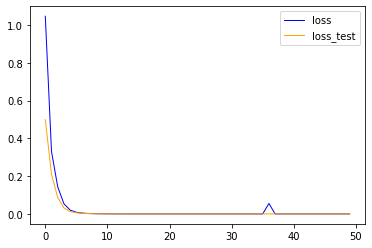

In [9]:
plt.plot(epoch_list, train_loss, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, test_loss, linewidth=1, color="orange",label="loss_test")
plt.legend()

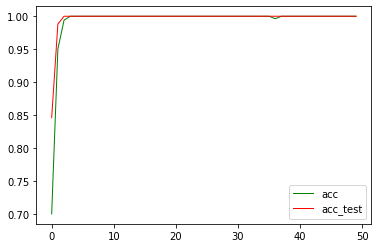

In [10]:
plt.plot(epoch_list, train_acc, linewidth=1, color="green",label="acc")
plt.plot(epoch_list, test_acc, linewidth=1, color="red",label="acc_test")
plt.legend()

In [11]:
epoch_list, train_loss, test_loss, train_acc, test_acc = train(input_length=5, max_epoch=MAX_EPOCH, train_steps=TRAIN_STEPS, eval_freq=EVAL_FREQ)

start training LSTM...


  2%|▏         | 1/50 [00:03<02:46,  3.40s/it]

TRAIN epoch: 1, loss : 1.242125, ACC: 0.556002
TEST epoch: 1, loss : 0.572034, ACC: 0.920019


  4%|▍         | 2/50 [00:06<02:43,  3.41s/it]

TRAIN epoch: 2, loss : 0.401996, ACC: 0.900062
TEST epoch: 2, loss : 0.233744, ACC: 0.990640


  6%|▌         | 3/50 [00:10<02:40,  3.42s/it]

TRAIN epoch: 3, loss : 0.193381, ACC: 0.971689
TEST epoch: 3, loss : 0.105650, ACC: 1.000000


  8%|▊         | 4/50 [00:13<02:37,  3.43s/it]

TRAIN epoch: 4, loss : 0.131978, ACC: 0.976717
TEST epoch: 4, loss : 0.058959, ACC: 1.000000


 10%|█         | 5/50 [00:17<02:42,  3.61s/it]

TRAIN epoch: 5, loss : 0.038764, ACC: 1.000000
TEST epoch: 5, loss : 0.027465, ACC: 1.000000


 12%|█▏        | 6/50 [00:21<02:39,  3.62s/it]

TRAIN epoch: 6, loss : 0.020237, ACC: 1.000000
TEST epoch: 6, loss : 0.014483, ACC: 1.000000


 14%|█▍        | 7/50 [00:24<02:33,  3.56s/it]

TRAIN epoch: 7, loss : 0.010701, ACC: 1.000000
TEST epoch: 7, loss : 0.007736, ACC: 1.000000


 16%|█▌        | 8/50 [00:28<02:26,  3.50s/it]

TRAIN epoch: 8, loss : 0.005767, ACC: 1.000000
TEST epoch: 8, loss : 0.004196, ACC: 1.000000


 18%|█▊        | 9/50 [00:31<02:21,  3.46s/it]

TRAIN epoch: 9, loss : 0.003149, ACC: 1.000000
TEST epoch: 9, loss : 0.002306, ACC: 1.000000


 20%|██        | 10/50 [00:34<02:14,  3.37s/it]

TRAIN epoch: 10, loss : 0.001735, ACC: 1.000000
TEST epoch: 10, loss : 0.001271, ACC: 1.000000


 22%|██▏       | 11/50 [00:37<02:10,  3.34s/it]

TRAIN epoch: 11, loss : 0.000958, ACC: 1.000000
TEST epoch: 11, loss : 0.000703, ACC: 1.000000


 24%|██▍       | 12/50 [00:41<02:10,  3.43s/it]

TRAIN epoch: 12, loss : 0.000529, ACC: 1.000000
TEST epoch: 12, loss : 0.000389, ACC: 1.000000


 26%|██▌       | 13/50 [00:44<02:05,  3.40s/it]

TRAIN epoch: 13, loss : 0.000295, ACC: 1.000000
TEST epoch: 13, loss : 0.000219, ACC: 1.000000


 28%|██▊       | 14/50 [00:48<02:01,  3.39s/it]

TRAIN epoch: 14, loss : 0.000166, ACC: 1.000000
TEST epoch: 14, loss : 0.000123, ACC: 1.000000


 30%|███       | 15/50 [00:51<01:58,  3.39s/it]

TRAIN epoch: 15, loss : 0.000094, ACC: 1.000000
TEST epoch: 15, loss : 0.000070, ACC: 1.000000


 32%|███▏      | 16/50 [00:54<01:53,  3.33s/it]

TRAIN epoch: 16, loss : 0.000054, ACC: 1.000000
TEST epoch: 16, loss : 0.000041, ACC: 1.000000


 34%|███▍      | 17/50 [00:58<01:53,  3.43s/it]

TRAIN epoch: 17, loss : 0.000031, ACC: 1.000000
TEST epoch: 17, loss : 0.000023, ACC: 1.000000


 36%|███▌      | 18/50 [01:01<01:49,  3.43s/it]

TRAIN epoch: 18, loss : 0.000018, ACC: 1.000000
TEST epoch: 18, loss : 0.000014, ACC: 1.000000


 38%|███▊      | 19/50 [01:05<01:47,  3.48s/it]

TRAIN epoch: 19, loss : 0.000010, ACC: 1.000000
TEST epoch: 19, loss : 0.000008, ACC: 1.000000


 40%|████      | 20/50 [01:09<01:45,  3.51s/it]

TRAIN epoch: 20, loss : 0.000006, ACC: 1.000000
TEST epoch: 20, loss : 0.000005, ACC: 1.000000


 42%|████▏     | 21/50 [01:12<01:41,  3.49s/it]

TRAIN epoch: 21, loss : 0.000004, ACC: 1.000000
TEST epoch: 21, loss : 0.000003, ACC: 1.000000


 44%|████▍     | 22/50 [01:16<01:37,  3.50s/it]

TRAIN epoch: 22, loss : 0.000002, ACC: 1.000000
TEST epoch: 22, loss : 0.000002, ACC: 1.000000


 46%|████▌     | 23/50 [01:19<01:33,  3.47s/it]

TRAIN epoch: 23, loss : 0.000001, ACC: 1.000000
TEST epoch: 23, loss : 0.000001, ACC: 1.000000


 48%|████▊     | 24/50 [01:23<01:31,  3.51s/it]

TRAIN epoch: 24, loss : 0.000001, ACC: 1.000000
TEST epoch: 24, loss : 0.000001, ACC: 1.000000


 50%|█████     | 25/50 [01:26<01:29,  3.59s/it]

TRAIN epoch: 25, loss : 0.000000, ACC: 1.000000
TEST epoch: 25, loss : 0.000000, ACC: 1.000000


 52%|█████▏    | 26/50 [01:30<01:26,  3.59s/it]

TRAIN epoch: 26, loss : 0.000000, ACC: 1.000000
TEST epoch: 26, loss : 0.000000, ACC: 1.000000


 54%|█████▍    | 27/50 [01:34<01:23,  3.62s/it]

TRAIN epoch: 27, loss : 0.000000, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [01:37<01:21,  3.68s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [01:41<01:15,  3.61s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [01:45<01:13,  3.67s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [01:48<01:09,  3.65s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [01:52<01:04,  3.57s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [01:55<01:00,  3.53s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [01:59<00:56,  3.50s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [02:02<00:51,  3.45s/it]

TRAIN epoch: 35, loss : 0.000000, ACC: 1.000000
TEST epoch: 35, loss : 0.000000, ACC: 1.000000


 72%|███████▏  | 36/50 [02:05<00:47,  3.37s/it]

TRAIN epoch: 36, loss : 0.000000, ACC: 1.000000
TEST epoch: 36, loss : 0.000000, ACC: 1.000000


 74%|███████▍  | 37/50 [02:08<00:43,  3.34s/it]

TRAIN epoch: 37, loss : 0.000000, ACC: 1.000000
TEST epoch: 37, loss : 0.000000, ACC: 1.000000


 76%|███████▌  | 38/50 [02:12<00:39,  3.30s/it]

TRAIN epoch: 38, loss : 0.000000, ACC: 1.000000
TEST epoch: 38, loss : 0.000000, ACC: 1.000000


 78%|███████▊  | 39/50 [02:15<00:37,  3.37s/it]

TRAIN epoch: 39, loss : 0.499223, ACC: 0.959081
TEST epoch: 39, loss : 0.001788, ACC: 1.000000


 80%|████████  | 40/50 [02:19<00:34,  3.48s/it]

TRAIN epoch: 40, loss : 0.000723, ACC: 1.000000
TEST epoch: 40, loss : 0.000402, ACC: 1.000000


 82%|████████▏ | 41/50 [02:22<00:31,  3.49s/it]

TRAIN epoch: 41, loss : 0.000292, ACC: 1.000000
TEST epoch: 41, loss : 0.000209, ACC: 1.000000


 84%|████████▍ | 42/50 [02:26<00:28,  3.57s/it]

TRAIN epoch: 42, loss : 0.000161, ACC: 1.000000
TEST epoch: 42, loss : 0.000122, ACC: 1.000000


 86%|████████▌ | 43/50 [02:30<00:24,  3.53s/it]

TRAIN epoch: 43, loss : 0.000097, ACC: 1.000000
TEST epoch: 43, loss : 0.000075, ACC: 1.000000


 88%|████████▊ | 44/50 [02:33<00:21,  3.52s/it]

TRAIN epoch: 44, loss : 0.000061, ACC: 1.000000
TEST epoch: 44, loss : 0.000048, ACC: 1.000000


 90%|█████████ | 45/50 [02:36<00:17,  3.50s/it]

TRAIN epoch: 45, loss : 0.000040, ACC: 1.000000
TEST epoch: 45, loss : 0.000032, ACC: 1.000000


 92%|█████████▏| 46/50 [02:40<00:13,  3.43s/it]

TRAIN epoch: 46, loss : 0.000027, ACC: 1.000000
TEST epoch: 46, loss : 0.000022, ACC: 1.000000


 94%|█████████▍| 47/50 [02:43<00:10,  3.34s/it]

TRAIN epoch: 47, loss : 0.000018, ACC: 1.000000
TEST epoch: 47, loss : 0.000015, ACC: 1.000000


 96%|█████████▌| 48/50 [02:46<00:06,  3.38s/it]

TRAIN epoch: 48, loss : 0.000012, ACC: 1.000000
TEST epoch: 48, loss : 0.000010, ACC: 1.000000


 98%|█████████▊| 49/50 [02:50<00:03,  3.44s/it]

TRAIN epoch: 49, loss : 0.000009, ACC: 1.000000
TEST epoch: 49, loss : 0.000007, ACC: 1.000000


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]

TRAIN epoch: 50, loss : 0.000006, ACC: 1.000000
TEST epoch: 50, loss : 0.000005, ACC: 1.000000


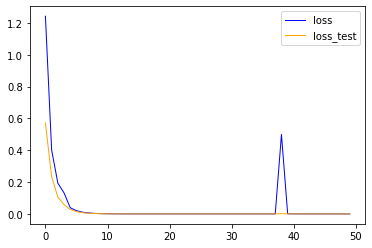

In [12]:
plt.plot(epoch_list, train_loss, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, test_loss, linewidth=1, color="orange",label="loss_test")
plt.legend()

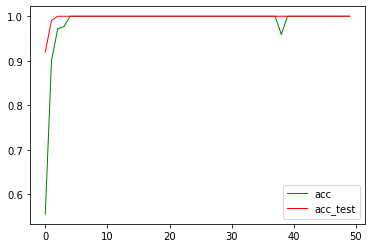

In [13]:
plt.plot(epoch_list, train_acc, linewidth=1, color="green",label="acc")
plt.plot(epoch_list, test_acc, linewidth=1, color="red",label="acc_test")
plt.legend()

In [14]:
epoch_list, train_loss, test_loss, train_acc, test_acc = train(input_length=7, max_epoch=MAX_EPOCH, train_steps=TRAIN_STEPS, eval_freq=EVAL_FREQ)

start training LSTM...


  2%|▏         | 1/50 [00:03<03:08,  3.85s/it]

TRAIN epoch: 1, loss : 1.499125, ACC: 0.436185
TEST epoch: 1, loss : 0.915230, ACC: 0.643642


  4%|▍         | 2/50 [00:07<03:07,  3.91s/it]

TRAIN epoch: 2, loss : 0.654254, ACC: 0.773747
TEST epoch: 2, loss : 0.684730, ACC: 0.641089


  6%|▌         | 3/50 [00:11<03:04,  3.92s/it]

TRAIN epoch: 3, loss : 0.410489, ACC: 0.891012
TEST epoch: 3, loss : 0.248403, ACC: 0.988397


  8%|▊         | 4/50 [00:15<03:00,  3.92s/it]

TRAIN epoch: 4, loss : 0.244232, ACC: 0.955600
TEST epoch: 4, loss : 0.134498, ACC: 1.000000


 10%|█         | 5/50 [00:19<02:55,  3.90s/it]

TRAIN epoch: 5, loss : 0.173463, ACC: 0.964728
TEST epoch: 5, loss : 0.076946, ACC: 1.000000


 12%|█▏        | 6/50 [00:23<02:51,  3.89s/it]

TRAIN epoch: 6, loss : 0.052674, ACC: 1.000000
TEST epoch: 6, loss : 0.036217, ACC: 1.000000


 14%|█▍        | 7/50 [00:27<02:43,  3.81s/it]

TRAIN epoch: 7, loss : 0.184518, ACC: 0.953125
TEST epoch: 7, loss : 0.030885, ACC: 1.000000


 16%|█▌        | 8/50 [00:30<02:40,  3.83s/it]

TRAIN epoch: 8, loss : 0.023739, ACC: 1.000000
TEST epoch: 8, loss : 0.018227, ACC: 1.000000


 18%|█▊        | 9/50 [00:34<02:38,  3.86s/it]

TRAIN epoch: 9, loss : 0.013959, ACC: 1.000000
TEST epoch: 9, loss : 0.010633, ACC: 1.000000


 20%|██        | 10/50 [00:38<02:31,  3.79s/it]

TRAIN epoch: 10, loss : 0.008008, ACC: 1.000000
TEST epoch: 10, loss : 0.005984, ACC: 1.000000


 22%|██▏       | 11/50 [00:42<02:29,  3.83s/it]

TRAIN epoch: 11, loss : 0.004482, ACC: 1.000000
TEST epoch: 11, loss : 0.003386, ACC: 1.000000


 24%|██▍       | 12/50 [00:46<02:26,  3.85s/it]

TRAIN epoch: 12, loss : 0.002538, ACC: 1.000000
TEST epoch: 12, loss : 0.001929, ACC: 1.000000


 26%|██▌       | 13/50 [00:50<02:21,  3.82s/it]

TRAIN epoch: 13, loss : 0.001440, ACC: 1.000000
TEST epoch: 13, loss : 0.001094, ACC: 1.000000


 28%|██▊       | 14/50 [00:53<02:16,  3.80s/it]

TRAIN epoch: 14, loss : 0.000813, ACC: 1.000000
TEST epoch: 14, loss : 0.000612, ACC: 1.000000


 30%|███       | 15/50 [00:57<02:11,  3.77s/it]

TRAIN epoch: 15, loss : 0.000455, ACC: 1.000000
TEST epoch: 15, loss : 0.000342, ACC: 1.000000


 32%|███▏      | 16/50 [01:01<02:08,  3.78s/it]

TRAIN epoch: 16, loss : 0.000256, ACC: 1.000000
TEST epoch: 16, loss : 0.000192, ACC: 1.000000


 34%|███▍      | 17/50 [01:05<02:07,  3.86s/it]

TRAIN epoch: 17, loss : 0.000145, ACC: 1.000000
TEST epoch: 17, loss : 0.000109, ACC: 1.000000


 36%|███▌      | 18/50 [01:09<02:04,  3.89s/it]

TRAIN epoch: 18, loss : 0.000082, ACC: 1.000000
TEST epoch: 18, loss : 0.000062, ACC: 1.000000


 38%|███▊      | 19/50 [01:13<02:02,  3.94s/it]

TRAIN epoch: 19, loss : 0.000047, ACC: 1.000000
TEST epoch: 19, loss : 0.000035, ACC: 1.000000


 40%|████      | 20/50 [01:17<01:56,  3.87s/it]

TRAIN epoch: 20, loss : 0.000027, ACC: 1.000000
TEST epoch: 20, loss : 0.000020, ACC: 1.000000


 42%|████▏     | 21/50 [01:20<01:50,  3.79s/it]

TRAIN epoch: 21, loss : 0.000015, ACC: 1.000000
TEST epoch: 21, loss : 0.000012, ACC: 1.000000


 44%|████▍     | 22/50 [01:24<01:44,  3.75s/it]

TRAIN epoch: 22, loss : 0.000009, ACC: 1.000000
TEST epoch: 22, loss : 0.000007, ACC: 1.000000


 46%|████▌     | 23/50 [01:28<01:41,  3.77s/it]

TRAIN epoch: 23, loss : 0.000005, ACC: 1.000000
TEST epoch: 23, loss : 0.000004, ACC: 1.000000


 48%|████▊     | 24/50 [01:31<01:37,  3.77s/it]

TRAIN epoch: 24, loss : 0.000003, ACC: 1.000000
TEST epoch: 24, loss : 0.000002, ACC: 1.000000


 50%|█████     | 25/50 [01:35<01:32,  3.71s/it]

TRAIN epoch: 25, loss : 0.000002, ACC: 1.000000
TEST epoch: 25, loss : 0.000001, ACC: 1.000000


 52%|█████▏    | 26/50 [01:39<01:28,  3.68s/it]

TRAIN epoch: 26, loss : 0.000001, ACC: 1.000000
TEST epoch: 26, loss : 0.000001, ACC: 1.000000


 54%|█████▍    | 27/50 [01:42<01:25,  3.70s/it]

TRAIN epoch: 27, loss : 0.000001, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [01:46<01:21,  3.69s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [01:50<01:16,  3.67s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [01:53<01:14,  3.73s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [01:57<01:11,  3.75s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [02:01<01:06,  3.68s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [02:05<01:03,  3.71s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [02:09<01:00,  3.79s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [02:12<00:56,  3.75s/it]

TRAIN epoch: 35, loss : 0.000000, ACC: 1.000000
TEST epoch: 35, loss : 0.000000, ACC: 1.000000


 72%|███████▏  | 36/50 [02:16<00:51,  3.65s/it]

TRAIN epoch: 36, loss : 0.000000, ACC: 1.000000
TEST epoch: 36, loss : 0.000000, ACC: 1.000000


 74%|███████▍  | 37/50 [02:19<00:47,  3.69s/it]

TRAIN epoch: 37, loss : 0.000000, ACC: 1.000000
TEST epoch: 37, loss : 0.000000, ACC: 1.000000


 76%|███████▌  | 38/50 [02:23<00:44,  3.70s/it]

TRAIN epoch: 38, loss : 0.000000, ACC: 1.000000
TEST epoch: 38, loss : 0.000000, ACC: 1.000000


 78%|███████▊  | 39/50 [02:27<00:40,  3.67s/it]

TRAIN epoch: 39, loss : 0.000000, ACC: 1.000000
TEST epoch: 39, loss : 0.000000, ACC: 1.000000


 80%|████████  | 40/50 [02:30<00:36,  3.69s/it]

TRAIN epoch: 40, loss : 1.052333, ACC: 0.829053
TEST epoch: 40, loss : 0.128596, ACC: 0.931002


 82%|████████▏ | 41/50 [02:34<00:33,  3.76s/it]

TRAIN epoch: 41, loss : 0.054021, ACC: 0.984684
TEST epoch: 41, loss : 0.006289, ACC: 1.000000


 84%|████████▍ | 42/50 [02:38<00:30,  3.77s/it]

TRAIN epoch: 42, loss : 0.002706, ACC: 1.000000
TEST epoch: 42, loss : 0.001545, ACC: 1.000000


 86%|████████▌ | 43/50 [02:42<00:25,  3.68s/it]

TRAIN epoch: 43, loss : 0.000937, ACC: 1.000000
TEST epoch: 43, loss : 0.000639, ACC: 1.000000


 88%|████████▊ | 44/50 [02:45<00:22,  3.67s/it]

TRAIN epoch: 44, loss : 0.000441, ACC: 1.000000
TEST epoch: 44, loss : 0.000324, ACC: 1.000000


 90%|█████████ | 45/50 [02:49<00:18,  3.65s/it]

TRAIN epoch: 45, loss : 0.000231, ACC: 1.000000
TEST epoch: 45, loss : 0.000173, ACC: 1.000000


 92%|█████████▏| 46/50 [02:53<00:14,  3.74s/it]

TRAIN epoch: 46, loss : 0.000129, ACC: 1.000000
TEST epoch: 46, loss : 0.000098, ACC: 1.000000


 94%|█████████▍| 47/50 [02:57<00:11,  3.76s/it]

TRAIN epoch: 47, loss : 0.000075, ACC: 1.000000
TEST epoch: 47, loss : 0.000057, ACC: 1.000000


 96%|█████████▌| 48/50 [03:00<00:07,  3.73s/it]

TRAIN epoch: 48, loss : 0.000045, ACC: 1.000000
TEST epoch: 48, loss : 0.000034, ACC: 1.000000


 98%|█████████▊| 49/50 [03:04<00:03,  3.82s/it]

TRAIN epoch: 49, loss : 0.000027, ACC: 1.000000
TEST epoch: 49, loss : 0.000021, ACC: 1.000000


100%|██████████| 50/50 [03:08<00:00,  3.77s/it]

TRAIN epoch: 50, loss : 0.000017, ACC: 1.000000
TEST epoch: 50, loss : 0.000013, ACC: 1.000000


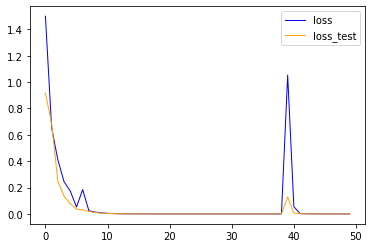

In [15]:
plt.plot(epoch_list, train_loss, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, test_loss, linewidth=1, color="orange",label="loss_test")
plt.legend()

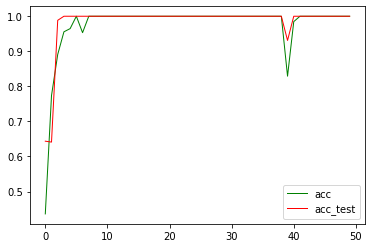

In [16]:
plt.plot(epoch_list, train_acc, linewidth=1, color="green",label="acc")
plt.plot(epoch_list, test_acc, linewidth=1, color="red",label="acc_test")
plt.legend()

In [18]:
epoch_list, train_loss, test_loss, train_acc, test_acc = train(input_length=10, max_epoch=MAX_EPOCH, train_steps=TRAIN_STEPS, eval_freq=EVAL_FREQ)

start training LSTM...


  2%|▏         | 1/50 [00:04<04:01,  4.93s/it]

TRAIN epoch: 1, loss : 1.624544, ACC: 0.372912
TEST epoch: 1, loss : 1.060612, ACC: 0.537129


  4%|▍         | 2/50 [00:09<03:45,  4.69s/it]

TRAIN epoch: 2, loss : 0.645375, ACC: 0.793472
TEST epoch: 2, loss : 0.751197, ACC: 0.623144


  6%|▌         | 3/50 [00:14<03:38,  4.66s/it]

TRAIN epoch: 3, loss : 0.337824, ACC: 0.916847
TEST epoch: 3, loss : 0.152496, ACC: 0.998762


  8%|▊         | 4/50 [00:18<03:35,  4.69s/it]

TRAIN epoch: 4, loss : 0.150761, ACC: 0.972231
TEST epoch: 4, loss : 0.062965, ACC: 1.000000


 10%|█         | 5/50 [00:24<03:41,  4.92s/it]

TRAIN epoch: 5, loss : 0.040924, ACC: 1.000000
TEST epoch: 5, loss : 0.026164, ACC: 1.000000


 12%|█▏        | 6/50 [00:29<03:40,  5.00s/it]

TRAIN epoch: 6, loss : 0.017995, ACC: 1.000000
TEST epoch: 6, loss : 0.012251, ACC: 1.000000


 14%|█▍        | 7/50 [00:34<03:37,  5.06s/it]

TRAIN epoch: 7, loss : 0.008695, ACC: 1.000000
TEST epoch: 7, loss : 0.006050, ACC: 1.000000


 16%|█▌        | 8/50 [00:39<03:32,  5.05s/it]

TRAIN epoch: 8, loss : 0.004320, ACC: 1.000000
TEST epoch: 8, loss : 0.003018, ACC: 1.000000


 18%|█▊        | 9/50 [00:44<03:25,  5.01s/it]

TRAIN epoch: 9, loss : 0.002153, ACC: 1.000000
TEST epoch: 9, loss : 0.001520, ACC: 1.000000


 20%|██        | 10/50 [00:49<03:18,  4.96s/it]

TRAIN epoch: 10, loss : 0.001101, ACC: 1.000000
TEST epoch: 10, loss : 0.000785, ACC: 1.000000


 22%|██▏       | 11/50 [00:54<03:15,  5.01s/it]

TRAIN epoch: 11, loss : 0.000580, ACC: 1.000000
TEST epoch: 11, loss : 0.000422, ACC: 1.000000


 24%|██▍       | 12/50 [00:59<03:11,  5.05s/it]

TRAIN epoch: 12, loss : 0.000317, ACC: 1.000000
TEST epoch: 12, loss : 0.000236, ACC: 1.000000


 26%|██▌       | 13/50 [01:04<03:07,  5.06s/it]

TRAIN epoch: 13, loss : 0.000180, ACC: 1.000000
TEST epoch: 13, loss : 0.000135, ACC: 1.000000


 28%|██▊       | 14/50 [01:09<02:58,  4.97s/it]

TRAIN epoch: 14, loss : 0.000104, ACC: 1.000000
TEST epoch: 14, loss : 0.000079, ACC: 1.000000


 30%|███       | 15/50 [01:14<02:55,  5.02s/it]

TRAIN epoch: 15, loss : 0.000060, ACC: 1.000000
TEST epoch: 15, loss : 0.000046, ACC: 1.000000


 32%|███▏      | 16/50 [01:19<02:49,  4.98s/it]

TRAIN epoch: 16, loss : 0.000035, ACC: 1.000000
TEST epoch: 16, loss : 0.000026, ACC: 1.000000


 34%|███▍      | 17/50 [01:24<02:42,  4.93s/it]

TRAIN epoch: 17, loss : 0.000020, ACC: 1.000000
TEST epoch: 17, loss : 0.000015, ACC: 1.000000


 36%|███▌      | 18/50 [01:29<02:40,  5.03s/it]

TRAIN epoch: 18, loss : 0.000012, ACC: 1.000000
TEST epoch: 18, loss : 0.000009, ACC: 1.000000


 38%|███▊      | 19/50 [01:34<02:35,  5.02s/it]

TRAIN epoch: 19, loss : 0.000007, ACC: 1.000000
TEST epoch: 19, loss : 0.000005, ACC: 1.000000


 40%|████      | 20/50 [01:39<02:30,  5.03s/it]

TRAIN epoch: 20, loss : 0.000004, ACC: 1.000000
TEST epoch: 20, loss : 0.000003, ACC: 1.000000


 42%|████▏     | 21/50 [01:44<02:21,  4.87s/it]

TRAIN epoch: 21, loss : 0.000002, ACC: 1.000000
TEST epoch: 21, loss : 0.000002, ACC: 1.000000


 44%|████▍     | 22/50 [01:48<02:16,  4.88s/it]

TRAIN epoch: 22, loss : 0.000001, ACC: 1.000000
TEST epoch: 22, loss : 0.000001, ACC: 1.000000


 46%|████▌     | 23/50 [01:53<02:08,  4.76s/it]

TRAIN epoch: 23, loss : 0.000001, ACC: 1.000000
TEST epoch: 23, loss : 0.000001, ACC: 1.000000


 48%|████▊     | 24/50 [01:57<02:02,  4.71s/it]

TRAIN epoch: 24, loss : 0.000000, ACC: 1.000000
TEST epoch: 24, loss : 0.000000, ACC: 1.000000


 50%|█████     | 25/50 [02:02<01:57,  4.70s/it]

TRAIN epoch: 25, loss : 0.000000, ACC: 1.000000
TEST epoch: 25, loss : 0.000000, ACC: 1.000000


 52%|█████▏    | 26/50 [02:07<01:53,  4.73s/it]

TRAIN epoch: 26, loss : 0.000000, ACC: 1.000000
TEST epoch: 26, loss : 0.000000, ACC: 1.000000


 54%|█████▍    | 27/50 [02:12<01:50,  4.79s/it]

TRAIN epoch: 27, loss : 0.000000, ACC: 1.000000
TEST epoch: 27, loss : 0.000000, ACC: 1.000000


 56%|█████▌    | 28/50 [02:17<01:44,  4.76s/it]

TRAIN epoch: 28, loss : 0.000000, ACC: 1.000000
TEST epoch: 28, loss : 0.000000, ACC: 1.000000


 58%|█████▊    | 29/50 [02:21<01:37,  4.64s/it]

TRAIN epoch: 29, loss : 0.000000, ACC: 1.000000
TEST epoch: 29, loss : 0.000000, ACC: 1.000000


 60%|██████    | 30/50 [02:26<01:32,  4.63s/it]

TRAIN epoch: 30, loss : 0.000000, ACC: 1.000000
TEST epoch: 30, loss : 0.000000, ACC: 1.000000


 62%|██████▏   | 31/50 [02:30<01:26,  4.57s/it]

TRAIN epoch: 31, loss : 0.000000, ACC: 1.000000
TEST epoch: 31, loss : 0.000000, ACC: 1.000000


 64%|██████▍   | 32/50 [02:35<01:23,  4.65s/it]

TRAIN epoch: 32, loss : 0.000000, ACC: 1.000000
TEST epoch: 32, loss : 0.000000, ACC: 1.000000


 66%|██████▌   | 33/50 [02:40<01:20,  4.72s/it]

TRAIN epoch: 33, loss : 0.000000, ACC: 1.000000
TEST epoch: 33, loss : 0.000000, ACC: 1.000000


 68%|██████▊   | 34/50 [02:44<01:15,  4.72s/it]

TRAIN epoch: 34, loss : 0.000000, ACC: 1.000000
TEST epoch: 34, loss : 0.000000, ACC: 1.000000


 70%|███████   | 35/50 [02:49<01:10,  4.68s/it]

TRAIN epoch: 35, loss : 0.945246, ACC: 0.891940
TEST epoch: 35, loss : 0.564775, ACC: 0.723004


 72%|███████▏  | 36/50 [02:54<01:05,  4.71s/it]

TRAIN epoch: 36, loss : 0.398423, ACC: 0.821395
TEST epoch: 36, loss : 0.230375, ACC: 0.911665


 74%|███████▍  | 37/50 [02:59<01:01,  4.74s/it]

TRAIN epoch: 37, loss : 0.111092, ACC: 0.976717
TEST epoch: 37, loss : 0.030558, ACC: 1.000000


 76%|███████▌  | 38/50 [03:03<00:56,  4.73s/it]

TRAIN epoch: 38, loss : 0.013611, ACC: 1.000000
TEST epoch: 38, loss : 0.005491, ACC: 1.000000


 78%|███████▊  | 39/50 [03:08<00:52,  4.80s/it]

TRAIN epoch: 39, loss : 0.003248, ACC: 1.000000
TEST epoch: 39, loss : 0.001896, ACC: 1.000000


 80%|████████  | 40/50 [03:13<00:48,  4.80s/it]

TRAIN epoch: 40, loss : 0.001252, ACC: 1.000000
TEST epoch: 40, loss : 0.000810, ACC: 1.000000


 82%|████████▏ | 41/50 [03:18<00:43,  4.83s/it]

TRAIN epoch: 41, loss : 0.000553, ACC: 1.000000
TEST epoch: 41, loss : 0.000367, ACC: 1.000000


 84%|████████▍ | 42/50 [03:23<00:38,  4.82s/it]

TRAIN epoch: 42, loss : 0.000255, ACC: 1.000000
TEST epoch: 42, loss : 0.000174, ACC: 1.000000


 86%|████████▌ | 43/50 [03:28<00:34,  4.86s/it]

TRAIN epoch: 43, loss : 0.000125, ACC: 1.000000
TEST epoch: 43, loss : 0.000092, ACC: 1.000000


 88%|████████▊ | 44/50 [03:33<00:29,  4.88s/it]

TRAIN epoch: 44, loss : 0.000069, ACC: 1.000000
TEST epoch: 44, loss : 0.000053, ACC: 1.000000


 90%|█████████ | 45/50 [03:37<00:24,  4.84s/it]

TRAIN epoch: 45, loss : 0.000041, ACC: 1.000000
TEST epoch: 45, loss : 0.000032, ACC: 1.000000


 92%|█████████▏| 46/50 [03:42<00:19,  4.84s/it]

TRAIN epoch: 46, loss : 0.000025, ACC: 1.000000
TEST epoch: 46, loss : 0.000019, ACC: 1.000000


 94%|█████████▍| 47/50 [03:47<00:14,  4.81s/it]

TRAIN epoch: 47, loss : 0.000015, ACC: 1.000000
TEST epoch: 47, loss : 0.000012, ACC: 1.000000


 96%|█████████▌| 48/50 [03:52<00:09,  4.88s/it]

TRAIN epoch: 48, loss : 0.000010, ACC: 1.000000
TEST epoch: 48, loss : 0.000008, ACC: 1.000000


 98%|█████████▊| 49/50 [03:57<00:04,  4.82s/it]

TRAIN epoch: 49, loss : 0.000006, ACC: 1.000000
TEST epoch: 49, loss : 0.000005, ACC: 1.000000


100%|██████████| 50/50 [04:01<00:00,  4.84s/it]

TRAIN epoch: 50, loss : 0.000004, ACC: 1.000000
TEST epoch: 50, loss : 0.000003, ACC: 1.000000


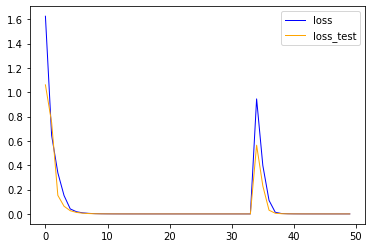

In [19]:
plt.plot(epoch_list, train_loss, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, test_loss, linewidth=1, color="orange",label="loss_test")
plt.legend()

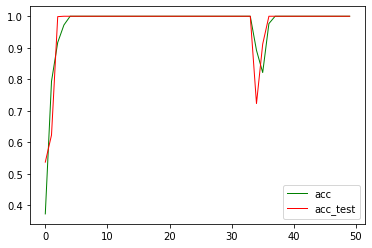

In [20]:
plt.plot(epoch_list, train_acc, linewidth=1, color="green",label="acc")
plt.plot(epoch_list, test_acc, linewidth=1, color="red",label="acc_test")
plt.legend()

In [21]:
epoch_list, train_loss, test_loss, train_acc, test_acc = train(input_length=15, max_epoch=MAX_EPOCH, train_steps=TRAIN_STEPS, eval_freq=EVAL_FREQ)

start training LSTM...


  2%|▏         | 1/50 [00:05<04:34,  5.60s/it]

TRAIN epoch: 1, loss : 1.784002, ACC: 0.307085
TEST epoch: 1, loss : 1.261134, ACC: 0.535891


  4%|▍         | 2/50 [00:11<04:35,  5.74s/it]

TRAIN epoch: 2, loss : 0.974207, ACC: 0.627243
TEST epoch: 2, loss : 0.641433, ACC: 0.793626


  6%|▌         | 3/50 [00:17<04:32,  5.79s/it]

TRAIN epoch: 3, loss : 0.618206, ACC: 0.775603
TEST epoch: 3, loss : 0.414761, ACC: 0.863165


  8%|▊         | 4/50 [00:23<04:31,  5.90s/it]

TRAIN epoch: 4, loss : 0.453852, ACC: 0.839573
TEST epoch: 4, loss : 0.292176, ACC: 0.899211


 10%|█         | 5/50 [00:29<04:23,  5.86s/it]

TRAIN epoch: 5, loss : 0.376699, ACC: 0.876624
TEST epoch: 5, loss : 0.323760, ACC: 0.895808


 12%|█▏        | 6/50 [00:34<04:08,  5.65s/it]

TRAIN epoch: 6, loss : 0.252423, ACC: 0.928605
TEST epoch: 6, loss : 0.180339, ACC: 0.914836


 14%|█▍        | 7/50 [00:40<04:05,  5.70s/it]

TRAIN epoch: 7, loss : 0.283085, ACC: 0.919477
TEST epoch: 7, loss : 0.683407, ACC: 0.786819


 16%|█▌        | 8/50 [00:46<04:06,  5.86s/it]

TRAIN epoch: 8, loss : 0.258167, ACC: 0.925665
TEST epoch: 8, loss : 0.094921, ACC: 1.000000


 18%|█▊        | 9/50 [00:52<04:01,  5.89s/it]

TRAIN epoch: 9, loss : 0.160090, ACC: 0.964496
TEST epoch: 9, loss : 1.718354, ACC: 0.480585


 20%|██        | 10/50 [00:58<03:57,  5.95s/it]

TRAIN epoch: 10, loss : 0.159422, ACC: 0.955987
TEST epoch: 10, loss : 0.045487, ACC: 1.000000


 22%|██▏       | 11/50 [01:04<03:54,  6.01s/it]

TRAIN epoch: 11, loss : 0.152230, ACC: 0.967358
TEST epoch: 11, loss : 0.037289, ACC: 1.000000


 24%|██▍       | 12/50 [01:10<03:49,  6.03s/it]

TRAIN epoch: 12, loss : 0.132348, ACC: 0.967048
TEST epoch: 12, loss : 0.029569, ACC: 1.000000


 26%|██▌       | 13/50 [01:16<03:44,  6.08s/it]

TRAIN epoch: 13, loss : 0.104550, ACC: 0.976098
TEST epoch: 13, loss : 0.023576, ACC: 1.000000


 28%|██▊       | 14/50 [01:22<03:35,  5.98s/it]

TRAIN epoch: 14, loss : 0.018236, ACC: 1.000000
TEST epoch: 14, loss : 0.014429, ACC: 1.000000


 30%|███       | 15/50 [01:28<03:27,  5.91s/it]

TRAIN epoch: 15, loss : 0.196492, ACC: 0.962407
TEST epoch: 15, loss : 0.020918, ACC: 1.000000


 32%|███▏      | 16/50 [01:34<03:25,  6.05s/it]

TRAIN epoch: 16, loss : 0.014860, ACC: 1.000000
TEST epoch: 16, loss : 0.011247, ACC: 1.000000


 34%|███▍      | 17/50 [01:40<03:21,  6.10s/it]

TRAIN epoch: 17, loss : 0.009018, ACC: 1.000000
TEST epoch: 17, loss : 0.007201, ACC: 1.000000


 36%|███▌      | 18/50 [01:46<03:14,  6.07s/it]

TRAIN epoch: 18, loss : 0.367849, ACC: 0.894802
TEST epoch: 18, loss : 0.143258, ACC: 0.914604


 38%|███▊      | 19/50 [01:53<03:08,  6.08s/it]

TRAIN epoch: 19, loss : 0.148740, ACC: 0.957689
TEST epoch: 19, loss : 0.016979, ACC: 1.000000


 40%|████      | 20/50 [01:59<03:01,  6.06s/it]

TRAIN epoch: 20, loss : 0.011134, ACC: 1.000000
TEST epoch: 20, loss : 0.007922, ACC: 1.000000


 42%|████▏     | 21/50 [02:05<02:55,  6.04s/it]

TRAIN epoch: 21, loss : 0.006317, ACC: 1.000000
TEST epoch: 21, loss : 0.005080, ACC: 1.000000


 44%|████▍     | 22/50 [02:11<02:51,  6.13s/it]

TRAIN epoch: 22, loss : 0.004143, ACC: 1.000000
TEST epoch: 22, loss : 0.003388, ACC: 1.000000


 46%|████▌     | 23/50 [02:17<02:42,  6.04s/it]

TRAIN epoch: 23, loss : 0.002750, ACC: 1.000000
TEST epoch: 23, loss : 0.002221, ACC: 1.000000


 48%|████▊     | 24/50 [02:22<02:34,  5.93s/it]

TRAIN epoch: 24, loss : 0.001780, ACC: 1.000000
TEST epoch: 24, loss : 0.001421, ACC: 1.000000


 50%|█████     | 25/50 [02:29<02:30,  6.00s/it]

TRAIN epoch: 25, loss : 0.001122, ACC: 1.000000
TEST epoch: 25, loss : 0.000881, ACC: 1.000000


 52%|█████▏    | 26/50 [02:35<02:24,  6.01s/it]

TRAIN epoch: 26, loss : 0.000685, ACC: 1.000000
TEST epoch: 26, loss : 0.000529, ACC: 1.000000


 54%|█████▍    | 27/50 [02:40<02:15,  5.91s/it]

TRAIN epoch: 27, loss : 0.000408, ACC: 1.000000
TEST epoch: 27, loss : 0.000311, ACC: 1.000000


 56%|█████▌    | 28/50 [02:46<02:09,  5.91s/it]

TRAIN epoch: 28, loss : 0.000238, ACC: 1.000000
TEST epoch: 28, loss : 0.000180, ACC: 1.000000


 58%|█████▊    | 29/50 [02:52<02:01,  5.76s/it]

TRAIN epoch: 29, loss : 0.000137, ACC: 1.000000
TEST epoch: 29, loss : 0.000104, ACC: 1.000000


 60%|██████    | 30/50 [02:57<01:55,  5.79s/it]

TRAIN epoch: 30, loss : 0.000078, ACC: 1.000000
TEST epoch: 30, loss : 0.000058, ACC: 1.000000


 62%|██████▏   | 31/50 [03:03<01:50,  5.84s/it]

TRAIN epoch: 31, loss : 0.000044, ACC: 1.000000
TEST epoch: 31, loss : 0.000033, ACC: 1.000000


 64%|██████▍   | 32/50 [03:09<01:45,  5.86s/it]

TRAIN epoch: 32, loss : 0.000024, ACC: 1.000000
TEST epoch: 32, loss : 0.000018, ACC: 1.000000


 66%|██████▌   | 33/50 [03:15<01:39,  5.86s/it]

TRAIN epoch: 33, loss : 0.536218, ACC: 0.908416
TEST epoch: 33, loss : 0.066677, ACC: 0.984375


 68%|██████▊   | 34/50 [03:21<01:32,  5.75s/it]

TRAIN epoch: 34, loss : 0.078128, ACC: 0.977800
TEST epoch: 34, loss : 0.004768, ACC: 1.000000


 70%|███████   | 35/50 [03:26<01:26,  5.77s/it]

TRAIN epoch: 35, loss : 0.215052, ACC: 0.954595
TEST epoch: 35, loss : 0.031574, ACC: 1.000000


 72%|███████▏  | 36/50 [03:33<01:23,  5.94s/it]

TRAIN epoch: 36, loss : 0.018156, ACC: 0.999923
TEST epoch: 36, loss : 0.009833, ACC: 1.000000


 74%|███████▍  | 37/50 [03:39<01:18,  6.01s/it]

TRAIN epoch: 37, loss : 0.006575, ACC: 1.000000
TEST epoch: 37, loss : 0.004587, ACC: 1.000000


 76%|███████▌  | 38/50 [03:45<01:13,  6.08s/it]

TRAIN epoch: 38, loss : 0.003408, ACC: 1.000000
TEST epoch: 38, loss : 0.002519, ACC: 1.000000


 78%|███████▊  | 39/50 [03:52<01:07,  6.17s/it]

TRAIN epoch: 39, loss : 0.001888, ACC: 1.000000
TEST epoch: 39, loss : 0.001412, ACC: 1.000000


 80%|████████  | 40/50 [03:57<01:00,  6.03s/it]

TRAIN epoch: 40, loss : 0.001065, ACC: 1.000000
TEST epoch: 40, loss : 0.000804, ACC: 1.000000


 82%|████████▏ | 41/50 [04:03<00:54,  6.00s/it]

TRAIN epoch: 41, loss : 0.000616, ACC: 1.000000
TEST epoch: 41, loss : 0.000469, ACC: 1.000000


 84%|████████▍ | 42/50 [04:09<00:46,  5.87s/it]

TRAIN epoch: 42, loss : 0.000376, ACC: 1.000000
TEST epoch: 42, loss : 0.000293, ACC: 1.000000


 86%|████████▌ | 43/50 [04:14<00:40,  5.79s/it]

TRAIN epoch: 43, loss : 0.000230, ACC: 1.000000
TEST epoch: 43, loss : 0.000181, ACC: 1.000000


 88%|████████▊ | 44/50 [04:20<00:34,  5.78s/it]

TRAIN epoch: 44, loss : 0.000144, ACC: 1.000000
TEST epoch: 44, loss : 0.000114, ACC: 1.000000


 90%|█████████ | 45/50 [04:26<00:29,  5.84s/it]

TRAIN epoch: 45, loss : 0.000090, ACC: 1.000000
TEST epoch: 45, loss : 0.000070, ACC: 1.000000


 92%|█████████▏| 46/50 [04:32<00:23,  5.83s/it]

TRAIN epoch: 46, loss : 0.000055, ACC: 1.000000
TEST epoch: 46, loss : 0.000045, ACC: 1.000000


 94%|█████████▍| 47/50 [04:38<00:17,  5.78s/it]

TRAIN epoch: 47, loss : 0.596202, ACC: 0.839264
TEST epoch: 47, loss : 0.343370, ACC: 0.849938


 96%|█████████▌| 48/50 [04:43<00:11,  5.78s/it]

TRAIN epoch: 48, loss : 0.144026, ACC: 0.972772
TEST epoch: 48, loss : 0.017796, ACC: 1.000000


 98%|█████████▊| 49/50 [04:49<00:05,  5.77s/it]

TRAIN epoch: 49, loss : 0.009942, ACC: 1.000000
TEST epoch: 49, loss : 0.005900, ACC: 1.000000


100%|██████████| 50/50 [04:55<00:00,  5.91s/it]

TRAIN epoch: 50, loss : 0.004055, ACC: 1.000000
TEST epoch: 50, loss : 0.002929, ACC: 1.000000


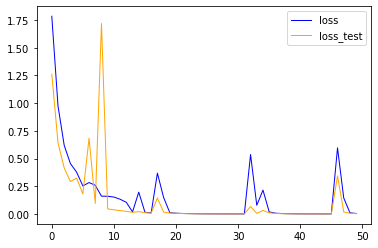

In [22]:
plt.plot(epoch_list, train_loss, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, test_loss, linewidth=1, color="orange",label="loss_test")
plt.legend()

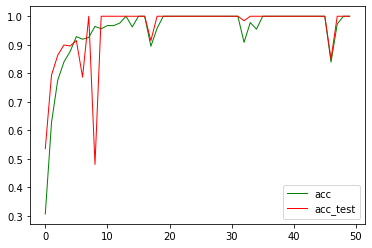

In [23]:
plt.plot(epoch_list, train_acc, linewidth=1, color="green",label="acc")
plt.plot(epoch_list, test_acc, linewidth=1, color="red",label="acc_test")
plt.legend()

True
